action [0.09949163347482681, -0.09981737285852432, -0.05450371652841568, 0.09999988973140717, 0.10000000149011612, -0.09997063130140305, -0.09991805255413055, 0.09999991953372955, -0.09999995678663254, 0.099985271692276]
action [0.09959619492292404, -0.09978005290031433, -0.03970545157790184, 0.09999991953372955, 0.09999999403953552, -0.09997337311506271, -0.09993463009595871, 0.09999990463256836, -0.09999994188547134, 0.09998048841953278]
action [0.09967471659183502, -0.09971883147954941, -0.022084636613726616, 0.09999992698431015, 0.09999999403953552, -0.0999753400683403, -0.09994583576917648, 0.09999988228082657, -0.09999991208314896, 0.099972665309906]
action [0.09974364191293716, -0.0996197909116745, -0.0007942845113575459, 0.09999994188547134, 0.09999999403953552, -0.09997662156820297, -0.09995339065790176, 0.09999984502792358, -0.09999986737966537, 0.09995963424444199]
action [0.09979745000600815, -0.0994596853852272, 0.020352335646748543, 0.09999994188547134, 0.0999999865889549

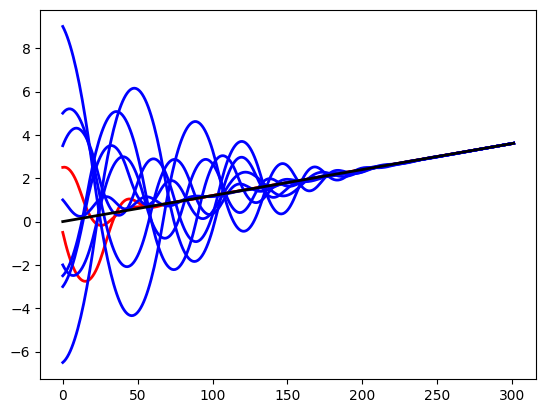

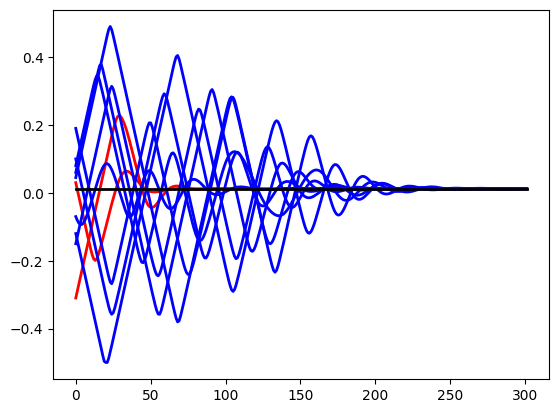

In [1]:
from myEnv_dual_a11 import MultiAgentEnv
import torch
import torch.nn.functional as F
import numpy as np


class PolicyNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNetContinuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_std = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mu = 0.1*torch.tanh(self.fc_mu(x))
        std = F.softplus(self.fc_std(x)) + 0.001
        return mu, std


class PPOContinuous:
    ''' 处理连续动作的PPO算法 '''

    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, epochs, eps, gamma, device):
        self.actor = PolicyNetContinuous(state_dim, hidden_dim,
                                         action_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs
        self.eps = eps
        self.device = device

    def take_action(self, state):
        state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device)
        mu, sigma = self.actor(state)
        action = mu
        action = action.tolist()[0]
        return action


actor_lr = 1e-5
critic_lr = 1e-4
num_episodes = 100
hidden_dim = 128
gamma = 0.95
lmbda = 0.9
epochs = 10
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'myEnv'
env = MultiAgentEnv()
torch.manual_seed(0)
state_dim = 4
action_dim = 1  # 连续动作空间

agents = []
for i in range(2):
    agents.append(
        PPOContinuous(state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                      lmbda, epochs, eps, gamma, device))

state = env.reset()
# 加载模型
agents[0].actor.load_state_dict(torch.load('MAPPO_dual/a_7_v_0.5_t_300_act_0.02/actor0.pth'))
agents[1].actor.load_state_dict(torch.load('MAPPO_dual/a_7_v_0.5_t_300_act_0.02/actor1.pth'))
#agents[0].actor.load_state_dict(torch.load('MAPPO_dual/actor0.pth'))
#agents[1].actor.load_state_dict(torch.load('MAPPO_dual/actor1.pth'))

# 循环，直到环境结束
done = False
while not done:
    actions = []
    actions_list = []
    for i in range(env.n_agents - 1):
        if i < env.dirct:
            action = agents[0].take_action(state[i])
        else:
            action = agents[1].take_action(state[i])
        actions.append(action)
        action = action[0]
        actions_list.append(action)

    print("action", actions_list)
    state, reward, done, error, _ = env.step(actions)  # 执行动作

env.render()  # 显示环境

env.close()